In [2]:
import pyscf
import ctypes
import numpy as np
from pyscf import dft
from pyscf import gto
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyscf import lib
from pyscf.dft import libxc
from pyscf.dft import numint
from pyscf.dft import xc_deriv


# Modify matplotlib defaults

In [3]:
import matplotlib as mpl
mpl.rcParams["font.size"] = 14
mpl.rcParams["text.color"] = "grey"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9"

Define the geometry of the $H_2$ molecule

In [4]:
mol=gto.Mole()
mol.atom='''
    H 0 0 -1
    H 0 0 1
'''#Z-matrix input format
mol.basis='cc-pvdz'
mol.symmetry = True
mol.build()
mylda = dft.RKS(mol)
mylda.xc = 'lda,vwn'
mylda.kernel()

converged SCF energy = -0.973624038544093


-0.9736240385440929

Generate the spherical grid

In [5]:
#default level=3
#default integration grids use Bragg radii for atoms
#Treutler-Ahlrichs radial grids, Becke partitioning for grid weights
grids = dft.gen_grid.Grids(mol)
grids.build(with_non0tab=True)

Extract the components from the result

In [6]:
weights = grids.weights
coords = grids.coords
newcoords=coords.T
x,y,z=newcoords


In [7]:
print(x.shape)

(20048,)


In [8]:
print(coords.shape[0])
print(coords)
print(newcoords.shape)
print(newcoords)

20048
[[-4.66663009 -4.66663009 -6.55635621]
 [-5.24550627 -5.24550627 -7.1352324 ]
 [-5.98642966 -5.98642966 -7.87615579]
 ...
 [10.07128293  5.3444306  11.96100905]
 [ 4.27346769  8.05311275  9.94283887]
 [ 5.3444306  10.07128293 11.96100905]]
(3, 20048)
[[-4.66663009 -5.24550627 -5.98642966 ... 10.07128293  4.27346769
   5.3444306 ]
 [-4.66663009 -5.24550627 -5.98642966 ...  5.3444306   8.05311275
  10.07128293]
 [-6.55635621 -7.1352324  -7.87615579 ... 11.96100905  9.94283887
  11.96100905]]


Use matplotlib to visualize the grid. We include the weights for each point for visualization purposes only. These values are required when integrating

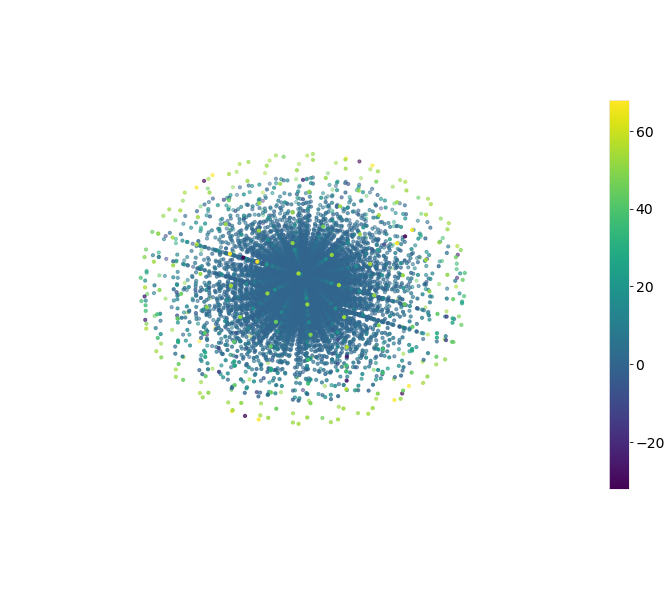

In [9]:
# Use matplotlib to visualize the grid. 
# We include the weights for each point for visualization purposes only. These values are required when integrating functions on this grid. 

fig = plt.figure(figsize=(9,8))
ax = Axes3D(fig)
ax.set_axis_off()
p = ax.scatter(x, y, z, c=weights, s=10)
plt.colorbar(p, fraction=0.030, pad=0.04)


Plot the densier grid

In [10]:

grids = dft.gen_grid.Grids(mol)
grids.level=7
grids.build(with_non0tab=True)

102816


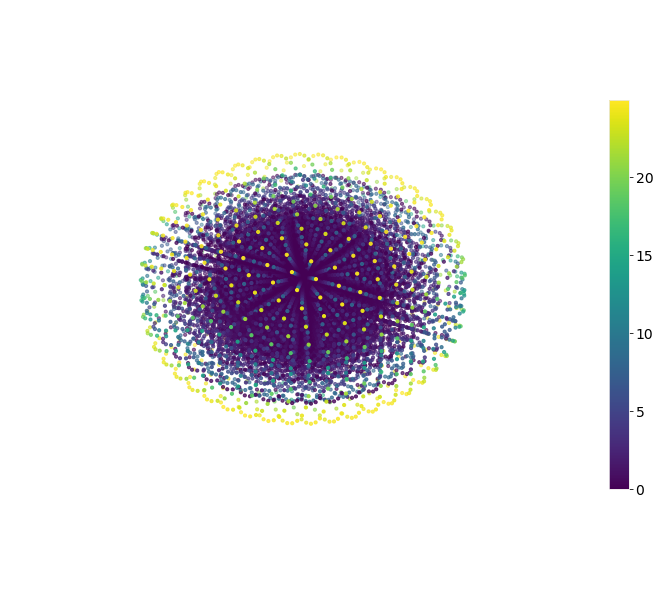

In [11]:
weights = grids.weights
coords = grids.coords
print(coords.shape[0])
newcoords=coords.T
x,y,z=newcoords
fig = plt.figure(figsize=(9,8))
ax = Axes3D(fig)
ax.set_axis_off()
p = ax.scatter(x, y, z, c=weights, s=10)
plt.colorbar(p, fraction=0.030, pad=0.04)

SCF calculation

In this part we want to get the density on this spherical grid. After getting phi matrix on the grid, I tried to calculate with numint and by hand.

In [12]:
#numint method
#density matrix
dm = mylda.make_rdm1()
print('dimension for the density matrix:',dm.shape)
# Evaluate AO values(phi matrix) on this grid
ao_value_grid = numint.eval_ao(mol, coords, deriv=1)
print(ao_value_grid.shape)
print("dimension for phi matrix:",ao_value_grid[0].shape)
#the value for phi matrix and the first derivative
phi=ao_value_grid[0]
phix=ao_value_grid[1]
phiy=ao_value_grid[2]
phiz=ao_value_grid[3]

# Compute the density on this grid
rho_grid = numint.eval_rho(mol, ao_value_grid, dm,xctype='GGA')#detail
print('total number of shells %d, total number of AO functions %d' %
      (mol.nbas, mol.nao_nr()))
print('how the ao functions are assigned to each shell',mol.ao_loc_nr())

dimension for the density matrix: (10, 10)
(4, 102816, 10)
dimension for phi matrix: (102816, 10)
total number of shells 6, total number of AO functions 10
how the ao functions are assigned to each shell [ 0  1  2  5  6  7 10]


In [13]:
#by hand
rho = np.einsum('pm,mn,pn->p', phi,dm,phi, optimize=True)
rhox = np.einsum('pm,mn,pn->p',phix,dm,phi)+np.einsum('pm,mn,pn->p',phi,dm,phix)
print('difference of rho between 2 methods', rho-rho_grid[0])
print('diffenrence of rhox between 2 methods', rhox-rho_grid[1])


difference of rho between 2 methods [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.50463277e-36
 -1.14794370e-41  0.00000000e+00]
diffenrence of rhox between 2 methods [ 0.00000000e+00 -4.13590306e-25  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00 -2.67276471e-51]


Try to define the exchange correlation functional with libxc

In [14]:
#pbe
#correlation part
#libxc components
#exchange part
def evalex(rho):
    ex=np.zeros(rho.shape[0])
    for i in range(rho.shape[0]):
        ex[i]=np.power(rho[i],1/3)*(-3/4)*(3/np.pi)**(1/3) #exchange correlation energy density
    Ex=np.einsum('p,p,p->',ex,rho,weights)
    vxrho=np.zeros(rho.shape[0])
    #vxrho 
    for j in range(rho.shape[0]):
        vxrho[j]=ex[j]+rho[j]*(1/3)*np.power(rho[j],-2/3)*(-3/4)*(3/np.pi)**(1/3)
    V = np.einsum('pb,p,p,pa->ab', phi, vxrho, weights, phi, optimize=True)
    return Ex,V

In [15]:
#correlation part
_itrf= lib.load_library('libxc_itrf')
def evalc(rho):
    #create a list for fn_ids and facs
    hyb, fn_facs = dft.libxc.parse_xc('LDA_C_VWN')
    fn_ids = [x[0] for x in fn_facs]
    facs   = [x[1] for x in fn_facs]
    omega=[0] * len(facs)
    #XC_NVAR('LDA', 0): (1, 1)
    #only density is the variable
    spin=0
    nvar, xlen = xc_deriv._XC_NVAR['LDA', spin]
    ngrids = rho.shape[-1]
    #deriv=1 (corrlation)
    deriv=1
    #outlen=1
    outlen = lib.comb(xlen+deriv, deriv)
    out = np.zeros((outlen,ngrids))
    n = len(fn_ids)
    density_threshold=0
    _itrf.LIBXC_eval_xc(ctypes.c_int(n),
                            (ctypes.c_int*n)(*fn_ids),
                            (ctypes.c_double*n)(*facs),
                            (ctypes.c_double*n)(*omega),
                            ctypes.c_int(spin), ctypes.c_int(deriv),
                            ctypes.c_int(nvar), ctypes.c_int(ngrids),
                            ctypes.c_int(outlen),
                            rho.ctypes.data_as(ctypes.c_void_p),
                            out.ctypes.data_as(ctypes.c_void_p),
                            ctypes.c_double(density_threshold))
    Ec= np.einsum('p,p,p->',out[0],rho,weights)
    Vc = np.einsum('pb,p,p,pa->ab', phi, out[1], weights, phi, optimize=True)
    return Ec, Vc

Begin SCF loop

In [16]:
#define the following integrals using pyscf
T = mol.intor('int1e_kin') 
V = mol.intor('int1e_nuc') 
S = mol.intor('int1e_ovlp')
I = mol.intor('int2e')

#our core hamiltonian
H=T+V

#we need to construct the matrix that diagonalizes S
e, U = np.linalg.eigh(S)
A = U @ np.diag(e**-0.5) @ U.T

#We are doing a restricted calculation, so each orbital contains 2 electrons
ndocc= mol.nelectron // 2

# Initial guess at D using just H_core 

F_p = A.dot(H).dot(A)
# Diagonalize F_p for eigenvalues & eigenvectors with NumPy
e, C_p = np.linalg.eigh(F_p)
# Transform C_p back into AO basis
C = A.dot(C_p)
# Grab occupied orbitals
C_occ = C[:, :ndocc]
# Build density matrix from occupied orbitals
D = 2 * np.einsum('pi,qi->pq', C_occ, C_occ, optimize=True)
print(D.shape)

(10, 10)


In [17]:
# Begin SCF Iterations
print('==> Starting SCF Iterations <==\n')
E_old = 0.0

#this is for DIIS
# Trial & Residual Vector Lists
F_list = []
DIIS_RESID = []


# Maximum SCF iterations
MAXITER = 40
# Energy convergence criterion
E_conv = 1.0e-8
D_conv = 1.0e-6

for scf_iter in range(1, MAXITER + 1):
    # Build Fock matrix
    #print(D)
    J = np.einsum('pqrs,rs->pq', I, D, optimize=True)
    rho_grid= np.einsum('pm,mn,pn->p', phi,D/2,phi, optimize=True)
    Ex,vx = evalex(rho)
    Ec,vc = evalc(rho)
    Exc=Ex+Ec
    vxc = vx + vc
    F = H + J + vxc

    H_E = np.sum(D * H)
    J_E = 0.5 * np.sum(D * J)
        
    # Build DIIS Residual
    diis_r = A.dot(F.dot(D).dot(S) - S.dot(D).dot(F)).dot(A)
    # Append trial & residual vectors to lists
    F_list.append(F)
    DIIS_RESID.append(diis_r)
    
    
    SCF_E = H_E + J_E + Exc + mol.energy_nuc()#different 
    dE = SCF_E - E_old
    dRMS = np.mean(diis_r**2)**0.5
    print('SCF Iteration %3d: Energy = %4.16f dE = % 1.5E dRMS = %1.5E' % (scf_iter, SCF_E, dE, dRMS))

    # Check for convergence
    if (abs(dE) < E_conv) and (dRMS < D_conv):
        break
    E_old = SCF_E
    
    #DIIS procedure
    if scf_iter >= 2:
        # Build B matrix
        B_dim = len(F_list) + 1
        B = np.empty((B_dim, B_dim))
        B[-1, :] = -1
        B[:, -1] = -1
        B[-1, -1] = 0
        for i in range(len(F_list)):
            for j in range(len(F_list)):
                B[i, j] = np.einsum('ij,ij->', DIIS_RESID[i], DIIS_RESID[j], optimize=True)

        # Build RHS of Pulay equation 
        rhs = np.zeros((B_dim))
        rhs[-1] = -1
               
        # Solve Pulay equation for c_i's with NumPy
        coeff = np.linalg.solve(B, rhs)
        
        # Build DIIS Fock matrix
        F = np.zeros_like(F)
        for x in range(coeff.shape[0] - 1):
            F += coeff[x] * F_list[x]
    

    
    # Compute new orbital guess
    F_p = A.dot(F).dot(A)
    e, C_p = np.linalg.eigh(F_p)
    C = A.dot(C_p)
    C_occ = C[:, :ndocc]
    D = 2* np.einsum('pi,qi->pq', C_occ, C_occ, optimize=True)

# Post iterations
print('\nSCF converged.')
print(f'Final RHF Energy: {SCF_E:.13f} [Eh]')
# get_veff calculates columb energy (J) + XC, and each part is accessbile with .ecoul or .exc
# Coulomb energy (Hartree energy)
print(f"Coulomb energy: {J_E} Hartree")
# Exchange-correlation energy
print(f"Exchange-correlation energy: {Exc} Hartree")

# Nuclear repulsion energy
print(f"Nuclear repulsion energy: {mol.energy_nuc()} Hartree")

==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -0.9264759873296302 dE = -9.26476E-01 dRMS = 2.66711E-02
SCF Iteration   2: Energy = -0.9839246057395992 dE = -5.74486E-02 dRMS = 7.87925E-03
SCF Iteration   3: Energy = -0.9730474711870336 dE =  1.08771E-02 dRMS = 4.37225E-04
SCF Iteration   4: Energy = -0.9736271133340237 dE = -5.79642E-04 dRMS = 1.92167E-06
SCF Iteration   5: Energy = -0.9736241981794687 dE =  2.91515E-06 dRMS = 5.97114E-10
SCF Iteration   6: Energy = -0.9736241981854663 dE = -5.99765E-12 dRMS = 6.02075E-10

SCF converged.
Final RHF Energy: -0.9736241981855 [Eh]
Coulomb energy: 0.8508821883798443 Hartree
Exchange-correlation energy: -0.47999790039542733 Hartree
Nuclear repulsion energy: 0.26458860546 Hartree


In [23]:
#compare with model calculaton using pyscf.dft
mylda = dft.RKS(mol)
mylda.xc = 'lda,vwn'
mylda.kernel()

# Exchange-correlation energy
print(f"Exchange-correlation energy: {mylda.get_veff().exc} Hartree")
dm = mylda.make_rdm1()
print(dm.shape)
rho_grid2=  numint.eval_rho(mol, ao_value_grid, dm,xctype='GGA')
print(rho_grid2.shape)
rho=rho_grid2[0]
extest,vxtest=evalex(rho)
ectest,vctest=evalc(rho)
exctext=extest+ectest
print(exctext)

converged SCF energy = -0.973624038544093
Exchange-correlation energy: -0.4799975054516773 Hartree
(10, 10)
(4, 102816)
-0.47999790039542467


In [21]:
# get_veff calculates columb energy (J) + XC, and each part is accessbile with .ecoul or .exc

# Coulomb energy (Hartree energy)
print(f"Coulomb energy: {mylda.get_veff().ecoul} Hartree")
# Exchange-correlation energy
print(f"Exchange-correlation energy: {mylda.get_veff().exc} Hartree")

# Nuclear repulsion energy
print(f"Nuclear repulsion energy: {mylda.energy_nuc()} Hartree")

# note we can also access the electronic energy with energy_elec(), which returns: (electronic energy, 2electron contribution)
print(f"Electronic energy: {mylda.energy_elec()[0]} Hartree")

Coulomb energy: 0.8508818213573673 Hartree
Exchange-correlation energy: -0.4799975054516755 Hartree
Nuclear repulsion energy: 0.26458860546 Hartree
Electronic energy: -1.2382126440040926 Hartree


Attempts to extract information from libxc

In [18]:
hyb, fn_facs = dft.libxc.parse_xc('LDA_X')
print(hyb)
print(fn_facs)
hyb2, fn_facs2=dft.libxc.parse_xc('LDA_C_WIGNER')
print(fn_facs2)

(0, 0, 0)
((1, 1),)
((2, 1),)


In [19]:
dft.libxc.xc_reference('LDA_C_WIGNER')

['E. Wigner.,  Trans. Faraday Soc. 34, 678 (1938)',
 'P. A. Stewart and P. M. W. Gill.,  J. Chem. Soc., Faraday Trans. 91, 4337-4341 (1995)']

In [20]:
exc, vxc = dft.libxc.eval_xc('SLATER', rho)[:2]#LDA contribution only (detail) Covalence approximation code

print('Exc = %.12f' % np.einsum('i,i,i->', exc, rho_grid[0], weights))


ValueError: einstein sum subscripts string contains too many subscripts for operand 1

In [ ]:
EXC=mylda.get_veff().exc
print(EXC)